## Скачаем датасет

Для этого я использую kaggle CLI. Но вы если хотите, можете использовать эту [ссылку](https://www.kaggle.com/bulentsiyah/for-simple-exercises-time-series-forecasting)

In [1]:
!kaggle datasets download bulentsiyah/for-simple-exercises-time-series-forecasting --unzip -p data


  0%|          | 0.00/1.84M [00:00<?, ?B/s]
 54%|#####4    | 1.00M/1.84M [00:00<00:00, 3.36MB/s]
100%|##########| 1.84M/1.84M [00:00<00:00, 3.96MB/s]
100%|##########| 1.84M/1.84M [00:00<00:00, 4.37MB/s]


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib

from scipy import stats
from scipy.special import inv_boxcox

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [17, 6]
matplotlib.rcParams['font.size'] = 12

Работать будем с датасетом по объёму продажи пива с 1992 по 2017 года. Сам датасет состоит из двух столбцов - даты и объёма продаж.

In [3]:
df = pd.read_csv('data/BeerWineLiquor.csv', index_col=0)
df.index = pd.to_datetime(df.index, format="%m/%d/%Y")
df.head(3)

,beer
date,
1992-01-01,1509
1992-02-01,1541
1992-03-01,1597


## Визуальная оценка

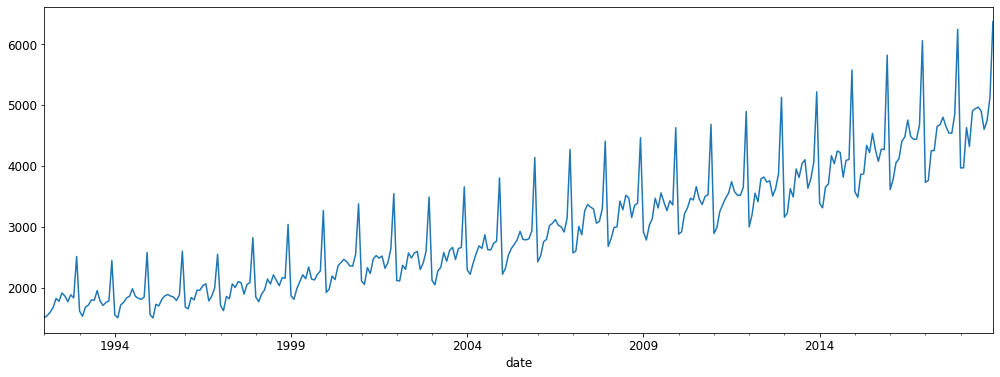

In [4]:
df.beer.plot()
plt.plot()

На графике видны тренд, сезонность и постепенно увеличивающаяся дисперсия. То есть ряд должен быть нестационарным.
Проверим это предположение с помощью теста Дики-Фуллера.

In [5]:
p = sm.tsa.stattools.adfuller(df.beer)[1]
print(f'Критерий Дики-Фуллера: p-value={p:.4f}')

Критерий Дики-Фуллера: p-value=1.0000


Для p-value 1 - максимальное значение. То есть наш ряд крайне нестационарен.

## Решение

Для начала _избавимся от дисперсии_

Критерий Дики-Фуллера: p-value=0.9795


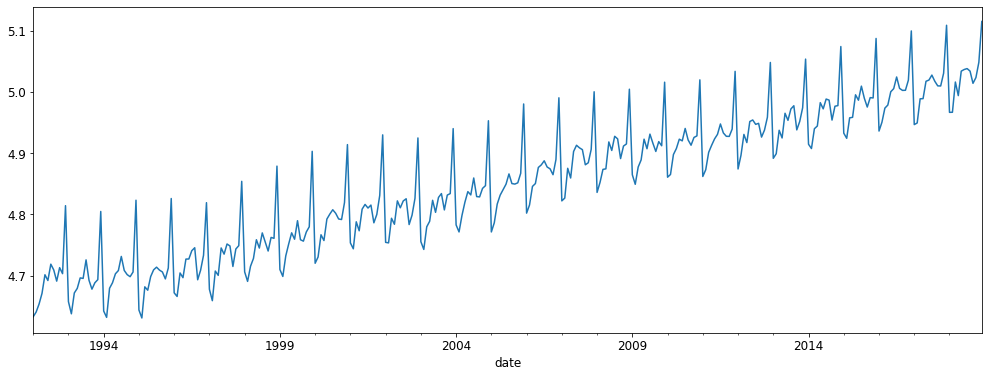

In [6]:
# Не стоит использовать слово lambda как название переменной. Это слово зарезервировано
df['boxcox'], lmbda = stats.boxcox(df.beer)

p = sm.tsa.stattools.adfuller(df.boxcox)[1]
print(f'Критерий Дики-Фуллера: p-value={p:.4f}')

df.boxcox.plot()
plt.plot()

Дисперсия стала более однородной. И p-value слегка уменьшилось. Но оно всё ещё гораздо больше $\alpha=0.05$

_Проведём сезонное дифференцирование_. Длина сезона в нашем случае равна 12. Это можно определить по графику. А когда по графику определить сложно можно включить логику. Сезон может также равняться 24 часам (сутки), 7 дням (неделя) или 30 дней (месяц).

Критерий Дики-Фуллера: p-value=0.0861


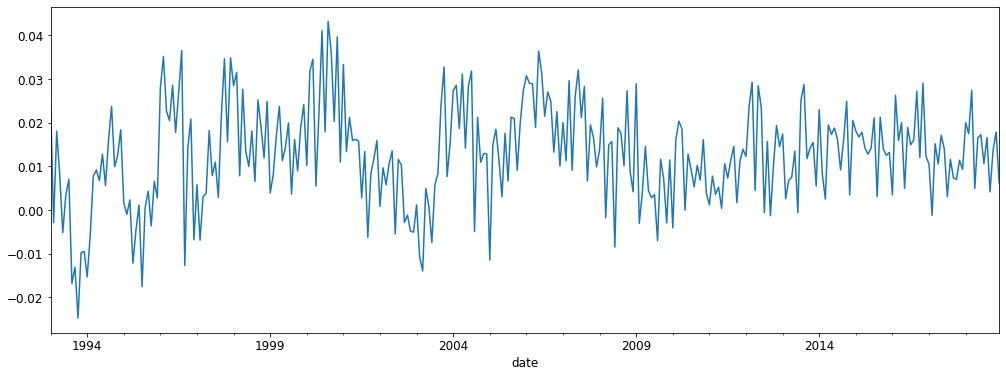

In [7]:
df['boxcox_shifted_S'] = df.boxcox - df.boxcox.shift(12)

p = sm.tsa.stattools.adfuller(df.boxcox_shifted_S[12:])[1]
print(f'Критерий Дики-Фуллера: p-value={p:.4f}')

df.boxcox_shifted_S[12:].plot()
plt.plot()

Как видите, одного сезонного дифференцирования хватило, чтобы сильно уменьшить сезонность в данных. Но несмотря на значительное уменьшение p-value, называть ряд стационарным мы всё ещё не будем, так как считаем, что $\alpha=0.05$. Но в некоторых случаях такой p-value был бы лучшим результатом. И тогда можно было сказать: "Ну ладно, ну с натяжечкой назову тебя стационарным"

__Важно:__ В примере я добавил _[12:]_ - то есть отсёк первые 12 элементов. Сделал я это, потому что после дифференцирования в новом ряду образовались NaN элементы.

Займёмся обычным дифференцированием.

Критерий Дики-Фуллера: p-value=0.0000


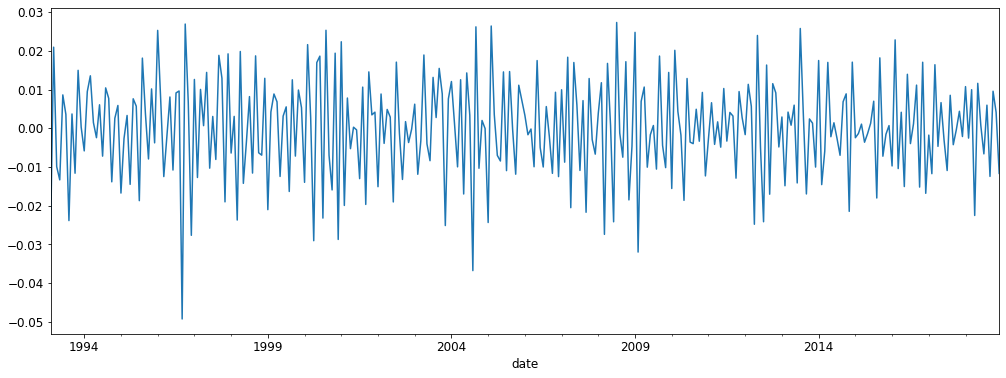

In [8]:
df['boxcox_shifted'] = df.boxcox_shifted_S - df.boxcox_shifted_S.shift(1)

p = sm.tsa.stattools.adfuller(df.boxcox_shifted[13:])[1]
print(f'Критерий Дики-Фуллера: p-value={p:.4f}')

df.boxcox_shifted[13:].plot()
plt.plot()

В этот раз к 12 существующим NaN'ам добавился ещё один. Поэтому отсекаем первые 13 значений.

Как видно на графике критерий Дики-Фуллера говорит, что такой ряд является стационарным. А значит его можно будет предсказывать.

## Но как же получить обратно исходный ряд?

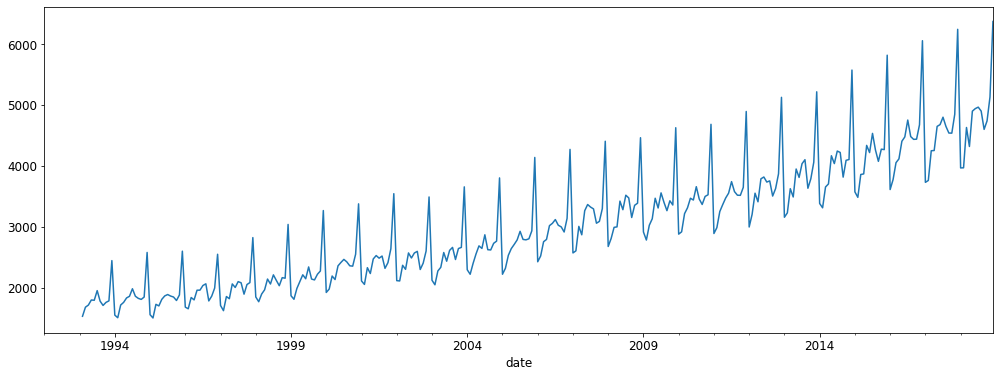

In [9]:
df['boxcox_shifted_S'] = df.boxcox_shifted + df.boxcox_shifted_S.shift(1)
df['boxcox'] = df.boxcox_shifted_S + df.boxcox.shift(12)
df['beer'] = inv_boxcox(df.boxcox, lmbda)

df.beer.plot()
plt.show()

Может показаться, что при обратных преобразованиях мы считаем данные на основании этих же данных:
```
df['boxcox_shifted_S'] = df.boxcox_shifted + df.boxcox_shifted_S.shift(1)
```
Но на самом деле `df.boxcox_shifted` как бы является прогнозом нашего ряда. А `df.boxcox_shifted_S.shift(1)` - это уже имеющиеся _сдвинутые_ данные. Ну то есть для прогноза в следующем месяца мы бы просто прибавили значение из нынешнего месяца.

А на этом всё. Теперь ты можешь застационарить всё, что хочешь.